In [63]:
import pandas as pd
import numpy as np
import seaborn as sns

btcflow = pd.read_excel("../data/processed/btc_exchange_netflow_20200510_20230310.xlsx")
btcflow


,Datetime,value,netflow
0,2020-05-10,8761.299747,-4493.684573
1,2020-05-11,8599.781947,-6684.599509
2,2020-05-12,8800.729722,-21674.370192
3,2020-05-13,9274.856203,-6959.345323
4,2020-05-14,9742.732853,1251.548752
...,...,...,...
1025,2023-03-01,23652.749774,2798.724745
1026,2023-03-02,23479.321887,789.610617
1027,2023-03-03,22359.217210,-3907.856738
1028,2023-03-04,22347.343924,-116.581407


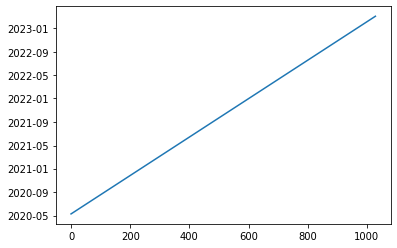

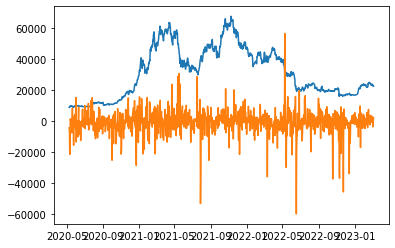

Datetime    0
value       0
netflow     0
dtype: int64
Datetime    datetime64[ns]
value              float64
netflow            float64
dtype: object


In [64]:
#check data quality
import matplotlib.pyplot as plt

# There are no missing date in data
plt.plot(btcflow.Datetime)
plt.show()

# There are no inconsistent data
plt.plot(btcflow.Datetime,btcflow.value)
plt.plot(btcflow.Datetime,btcflow.netflow)
plt.show()

# There are no na values, and datatype is suitable
print(btcflow.isna().sum())
print(btcflow.dtypes)

In [70]:
# x is input for MA,diff

def pos(row,flow):

    if row['MA_netflow'] < flow:
        return 1
    else:
        return 0
        
def buyholdpos(row):
    if row.isna().any():
        return 0
    else:
        return 1

# x is input for MA,diff
def btc_net_flow_strategy(x):

    btcflow['Chg_btc']= btcflow.value.pct_change()
    btcflow['MA_netflow'] = btcflow.netflow.rolling(window = x[0]).mean()
    btcflow['Position'] = btcflow.apply(lambda row: pos(row,x[1]),axis = 1)
    btcflow['cost'] = btcflow.apply(lambda row: 0.0005 if (row['Position'] == 1) else 0,axis = 1)
    btcflow['pnl'] = btcflow.Chg_btc*btcflow.Position.shift(1)
    btcflow['pnl_after_cost'] = btcflow.pnl - btcflow.cost
    btcflow['cumu'] = btcflow.pnl.cumsum()
    btcflow['dd'] = btcflow.cumu-btcflow.cumu.cummax()
    btcflow['bh_pos'] = btcflow.apply(lambda row: buyholdpos(row),axis =1)
    btcflow['bh_cost'] = btcflow.apply(lambda row: 0.0005 if (row['bh_pos'] == 1) else 0,axis = 1)
    btcflow['bh_pnl'] = btcflow.Chg_btc*btcflow.bh_pos.shift(1)
    btcflow['bh_pnl_after_cost'] = btcflow.bh_pnl - btcflow.bh_cost
    btcflow['bh_cumu'] = btcflow.bh_pnl.cumsum()
    btcflow['bh_dd'] = btcflow.bh_cumu-btcflow.bh_cumu.cummax()
    
    btcflow.fillna(0, inplace = True)
    
    data = {"BtcExchgFlow":{'TR':float(btcflow.cumu.tail(1)),
                      'AR':btcflow.pnl.mean()*365,
                      'Sharpe':btcflow.pnl.mean()/btcflow.pnl.std()*365**0.5,
                      'MDD':min(btcflow.dd),
                      'Calmar':btcflow.pnl.mean()*365/abs(min(btcflow.dd))},
    "BuyHold":{'TR':float(btcflow.bh_cumu.tail(1)),
                      'AR':btcflow.bh_pnl.mean()*365,
                      'Sharpe':btcflow.bh_pnl.mean()/btcflow.bh_pnl.std()*365**0.5,
                      'MDD':min(btcflow.bh_dd),
                      'Calmar':btcflow.bh_pnl.mean()*365/abs(min(btcflow.bh_dd))}}
    
    Perf = pd.DataFrame.from_dict(data, orient='index')

    
    return Perf

In [73]:
btc_net_flow_strategy((50,-400))

,TR,AR,Sharpe,MDD,Calmar
BtcExchgFlow,1.881491,0.666742,1.420191,-0.444901,1.498631
BuyHold,1.517956,0.537916,0.811231,-1.227655,0.438166


In [75]:
ma_param_grid = np.arange(2,101,1).tolist()
flow_param_grid = np.arange(0,-2000,-100).tolist()

param_grid = []
for i in ma_param_grid:
    row = []
    for j in flow_param_grid:
        row.append(btc_net_flow_strategy((i,j)).iloc[0,2])
    param_grid.append(row)
        



KeyboardInterrupt: 

In [ ]:
len(flow_param_grid)

20

In [ ]:
param_grid

[[0.8873839965780378,
  0.8873839965780378,
  0.8873839965780378,
  0.8873839965780378,
  0.8873839965780378,
  0.8873839965780378,
  0.8873839965780378,
  0.8873839965780378,
  0.8873839965780378,
  0.8873839965780378],
 [0.6080773837893068,
  0.6080773837893068,
  0.6080773837893068,
  0.6080773837893068,
  0.6080773837893068,
  0.6080773837893068,
  0.6080773837893068,
  0.6080773837893068,
  0.6080773837893068,
  0.6080773837893068],
 [0.5929441910405794,
  0.5929441910405794,
  0.5929441910405794,
  0.5929441910405794,
  0.5929441910405794,
  0.5929441910405794,
  0.5929441910405794,
  0.5929441910405794,
  0.5929441910405794,
  0.5929441910405794],
 [0.201676814046791,
  0.201676814046791,
  0.201676814046791,
  0.201676814046791,
  0.201676814046791,
  0.201676814046791,
  0.201676814046791,
  0.201676814046791,
  0.201676814046791,
  0.201676814046791],
 [0.5414770028636877,
  0.5414770028636877,
  0.5414770028636877,
  0.5414770028636877,
  0.5414770028636877,
  0.541477002863

In [ ]:
heat = pd.DataFrame(param_grid,columns = diff_param_grid, index = ma_param_grid)

In [ ]:
heat

,0.000,-0.005,-0.010,-0.015,-0.020,-0.025,-0.030,-0.035,-0.040,-0.045,-0.050,-0.055,-0.060,-0.065,-0.070,-0.075,-0.080,-0.085,-0.090,-0.095
2,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384,0.887384
3,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077,0.608077
4,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944,0.592944
5,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677,0.201677
6,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477,0.541477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840,-0.047840
97,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611,-0.026611
98,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881,0.083881
99,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932,0.104932


<AxesSubplot:>

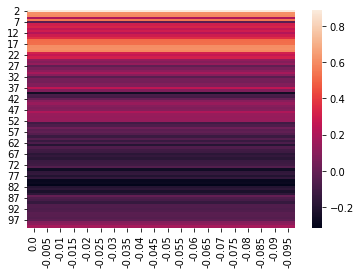

In [ ]:
sns.heatmap(heat)